In [1]:
import ray

ray.init(ignore_reinit_error=True)

2024-01-26 11:08:55,334	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.11.4
Ray version:,2.8.1


In [2]:
from ray import train, tune
from fastcore.xtras import Path


In [3]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.algorithm import Algorithm

from ray.tune.logger import pretty_print


2024-01-26 11:08:58,001	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.


In [4]:
import torch
import os
# Set device currently does nothing
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [5]:
from ray.rllib.env.wrappers.pettingzoo_env import ParallelPettingZooEnv
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.tune.registry import register_env
from torch import nn
#from ray.rllib.env.wrappers.pettingzoo_env import PettingZooEnv
from pettingzoo.butterfly import pistonball_v6


In [6]:
import supersuit as ss

In [7]:
from ray import train, tune
from fastcore.xtras import Path
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.algorithm import Algorithm
from ray.tune.logger import pretty_print

from ray.rllib.env.wrappers.pettingzoo_env import ParallelPettingZooEnv
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.tune.registry import register_env
from torch import nn
from ray.rllib.env.wrappers.pettingzoo_env import PettingZooEnv
from pettingzoo.butterfly import pistonball_v6
import supersuit as ss

import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import os

In [8]:
#no GPU support. Still an open issue:
#https://github.com/ray-project/ray/issues/28321
#tune.Tuner(tune.with_resources(0, resources={"cpu": 8, "gpu": 1}),...
#https://docs.ray.io/en/latest/tune/api/doc/ray.tune.with_resources.html
ray.get_gpu_ids()

[]

In [9]:
#grid search parameters
# tune.grid_search([0.01, 0.001])


In [10]:
#custom model example: https://docs.ray.io/en/latest/rllib/rllib-models.html

In [11]:
class CNNModelV2(TorchModelV2, nn.Module):
    def __init__(self, obs_space, act_space, num_outputs, *args, **kwargs):
        TorchModelV2.__init__(self, obs_space, act_space, num_outputs, *args, **kwargs)
        nn.Module.__init__(self)
        
        conv_filters = [32, 64, 64]
        
        if len(obs_space.shape)==4: 
            obs_sz=obs_space.shape[1:]
            chnl=obs_space.shape[1]
        else: 
            obs_sz=obs_space.shape
            chnl=obs_space.shape[0]
            
        model = nn.Sequential(
            nn.Conv2d(chnl, conv_filters[0], [3, 3], stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(conv_filters[0], conv_filters[1], [3, 3], stride=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(conv_filters[1], conv_filters[2], [3, 3], stride=(1, 1)),
            nn.ReLU(),
            nn.Flatten())
        
        n_channels=np.product(model(torch.rand(obs_sz)).shape)
        
        self.model=nn.Sequential(model, 
                                 (nn.Linear(n_channels, 512)),  
                                nn.ReLU(),
                                )
        self.policy_fn = nn.Linear(512, num_outputs)
        self.value_fn = nn.Linear(512, 1)

    def forward(self, input_dict, state, seq_lens):
        model_out = self.model(input_dict["obs"].permute(0, 3, 1, 2))
        self._value_out = self.value_fn(model_out)
        return self.policy_fn(model_out), state

    def value_function(self):
        return self._value_out.flatten()

In [12]:
ModelCatalog.register_custom_model("CNNModelV2", CNNModelV2)

In [13]:
def env_creator():
    env = pistonball_v6.env(
        n_pistons=12,
        time_penalty=-0.1,
        continuous=True,
        random_drop=True,
        random_rotate=True,
        ball_mass=0.75,
        ball_friction=0.3,
        ball_elasticity=1.5,
        max_cycles=125,
        render_mode="rgb_array",
    )
    env = ss.color_reduction_v0(env, mode="B") #uses blue channel instead of convert to grayscale
    env = ss.dtype_v0(env, "float32")
    env = ss.resize_v1(env, x_size=64, y_size=64)
    env = ss.normalize_obs_v0(env, env_min=-1, env_max=1)
    env = ss.frame_stack_v1(env, 5)
    return env

In [14]:
env = env_creator()
env_name = "pistonball_v6"
register_env(env_name, lambda config: PettingZooEnv(env_creator()))

In [15]:
# agent, model, and environment setup
param_space = (PPOConfig()
            .environment(env=env_name)
            .framework("torch")
            .debugging(log_level="ERROR")
            .training(train_batch_size=128,
                        lr=3e-4,
                        gamma=0.99,
                        lambda_=0.9,
                        use_gae=True,
                        clip_param=0.5,
                        grad_clip=10, # was None in example which led to nan errors
                        entropy_coeff=0.1,
                        vf_loss_coeff=0.25,
                        sgd_minibatch_size=64,
                        num_sgd_iter=10,))

# sets save directory and when to end training                        
run_config=train.RunConfig(name="my_MARL_tune",
                           storage_path=str(Path('.').resolve()/'saved_agents'),
                           stop={"training_iteration": 20}, #episodes_total, 10000
                           checkpoint_config=train.CheckpointConfig(
                                            checkpoint_score_attribute="episode_reward_mean",
                                            checkpoint_score_order="max"
                                                                   ))
#load configs into Tuner
tuner = tune.Tuner("PPO", run_config=run_config,
                   param_space=param_space,
                    )
#training model
results = tuner.fit()

(pid=78440) 2024-01-26 11:09:05,456	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
(RolloutWorker pid=78510) /Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/pettingzoo/utils/wrappers/base.py:58: UserWarning: The `observation_spaces` dictionary is deprecated. Use the `observation_space` function instead.
(RolloutWorker pid=78510)   warnings.warn(
(RolloutWorker pid=78510) /Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/pettingzoo/utils/wrappers/base.py:72: UserWarning: The `action_spaces` 

In [17]:
# Find best model
best_result = results.get_best_result(metric="episode_reward_max", mode="max")

# Get the best checkpoint corresponding to the best result.
best_checkpoint = best_result.checkpoint


algo = Algorithm.from_checkpoint(best_checkpoint.path)

/Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/ray/rllib/algorithms/algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This AP

In [18]:
best_checkpoint.path

'/Users/sbrewer/Documents/NAVAIR/RL_Scripts/saved_agents/my_MARL_tune/PPO_pistonball_v6_63219_00000_0_2024-01-03_13-03-24/checkpoint_000000'

In [19]:
policy = algo.get_policy()
#print(policy.get_weights())
model = policy.model

In [20]:
model

PPOTorchRLModule(
  (encoder): TorchActorCriticEncoder(
    (actor_encoder): TorchCNNEncoder(
      (net): Sequential(
        (0): TorchCNN(
          (cnn): Sequential(
            (0): ZeroPad2d((1, 1, 1, 1))
            (1): Conv2d(5, 32, kernel_size=(4, 4), stride=(2, 2))
            (2): ReLU()
            (3): ZeroPad2d((1, 1, 1, 1))
            (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
            (5): ReLU()
            (6): ZeroPad2d((1, 1, 1, 1))
            (7): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
            (8): ReLU()
            (9): ZeroPad2d((1, 1, 1, 1))
            (10): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
            (11): ReLU()
          )
        )
        (1): Flatten(start_dim=1, end_dim=-1)
      )
    )
    (critic_encoder): TorchCNNEncoder(
      (net): Sequential(
        (0): TorchCNN(
          (cnn): Sequential(
            (0): ZeroPad2d((1, 1, 1, 1))
            (1): Conv2d(5, 32, kernel_size=(4, 4), stride=

In [21]:
def env_creator_AEC():
    env = pistonball_v6.env(
        n_pistons=12,
        time_penalty=-0.1,
        continuous=True,
        random_drop=True,
        random_rotate=True,
        ball_mass=0.75,
        ball_friction=0.3,
        ball_elasticity=1.5,
        max_cycles=125,
        render_mode="rgb_array",
    )
    env = ss.color_reduction_v0(env, mode="B")
    env = ss.dtype_v0(env, "float32")
    env = ss.resize_v1(env, x_size=64, y_size=64)
    env = ss.normalize_obs_v0(env, env_min=-1, env_max=1)
    env = ss.frame_stack_v1(env, 5)
    return env


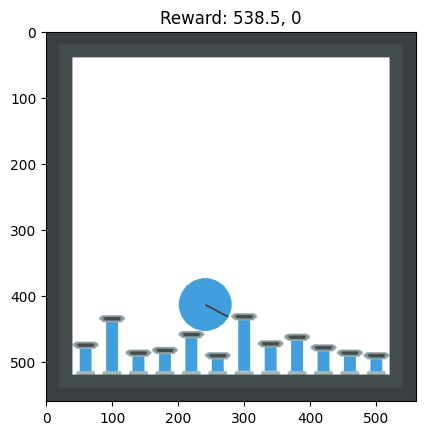

In [28]:
env = env_creator_AEC()
env_name = "pistonball_v6_AEC"
register_env(env_name, lambda config: PettingZooEnv(env_creator()))

N=1
reward_lst=[]
for n in range(N):

    episode_reward = 0    
    stp_cnt = 0
    
    env.reset()

    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        episode_reward += reward

        if termination or truncation:
            action = None
        else:
            action = algo.compute_single_action(observation)

        env.step(action)
        stp_cnt += 1
        if stp_cnt % (len(env.possible_agents) + 1) == 0 and n==N-1:
            clear_output(wait=True)
            plt.imshow( env.render())
            plt.title(f'Reward: {round(episode_reward,1)}, {n}')
            plt.show()
    
    reward_lst.append(episode_reward)
    
env.close()

In [26]:
import pandas as pd
pd.Series(reward_lst).describe()

count      3.000000
mean     -93.091287
std      118.725492
min     -180.848329
25%     -160.636930
50%     -140.425532
75%      -49.212766
max       42.000000
dtype: float64

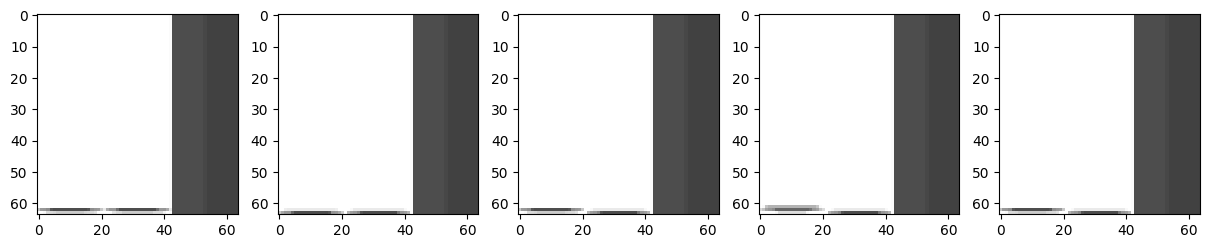

In [29]:
fig, axes = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    ax=axes[i]; ax.imshow(observation[:,:,i], cmap='gray',vmin=-1, vmax=1, interpolation='nearest')

In [59]:
observation[:,:,-1]

array([[-0.49019605, -0.49019605, -0.49019605, ...,  1.        ,
         1.        ,  1.        ],
       [-0.49019605, -0.49019605, -0.49019605, ...,  1.        ,
         1.        ,  1.        ],
       [-0.49019605, -0.49019605, -0.49019605, ...,  1.        ,
         1.        ,  1.        ],
       ...,
       [-0.49019605, -0.49019605, -0.49019605, ...,  0.18202639,
         0.22254896,  0.4699347 ],
       [-0.49019605, -0.49019605, -0.49019605, ...,  0.87740326,
         1.        ,  1.        ],
       [-0.49019605, -0.49019605, -0.49019605, ...,  1.        ,
         1.        ,  1.        ]], dtype=float32)

In [29]:
#env = env_creator()
#env_name = "pistonball_v6"
#register_env(env_name, lambda config: PettingZooEnv(env_creator()))

In [ ]:
env = pistonball_v6.parallel_env(render_mode="rgb_array")
observations, infos = env.reset()




In [30]:
env.reset()
while env.agents:
    actions = {agent: env.action_space(agent).sample() for agent in env.agents}
    
    observations, rewards, terminations, truncations, infos = env.step(actions)
    break
env.close()

/Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [24]:



reward_lst=[]

episode_reward = 0
stp_cnt = 0

env.reset()

while env.agents:
    
    actions = {agent: env.action_space(agent).sample() for agent in env.agents}
    
    observations, rewards, terminations, truncations, infos = env.step(actions)
    episode_reward +=sum(list(rewards.values()))

    stp_cnt += 1
    #if stp_cnt % (len(env.possible_agents) + 1) == 0 and n==N-1:
    clear_output(wait=True)
    plt.imshow( env.render())
    plt.title(f'Reward: {round(episode_reward,1)}, {n}')
    plt.show()

#reward_lst.append(episode_reward)

env.close()

/Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [47]:
#env = pistonball_v6.parallel_env(render_mode="rgb_array")
N=1
reward_lst=[]
for n in range(N):
    env.reset()

    episode_reward=0; stp_cnt=0


    while env.agents:
        # this is where you would insert your policy
        actions = {agent: env.action_space(agent).sample() for agent in env.agents}

        observations, rewards, terminations, truncations, infos = env.step(actions)
        episode_reward+=sum(list(rewards.values()))
        
        '''if n == N-1:            
            clear_output(wait=True)
            plt.imshow( env.render())
            plt.title(f'Reward: {int(episode_reward)}, Step Count: {stp_cnt}')
            plt.show()
            stp_cnt+=1   '''   
            
           

    
    reward_lst.append(episode_reward)
env.close()

/Users/sbrewer/anaconda3/envs/rllib/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

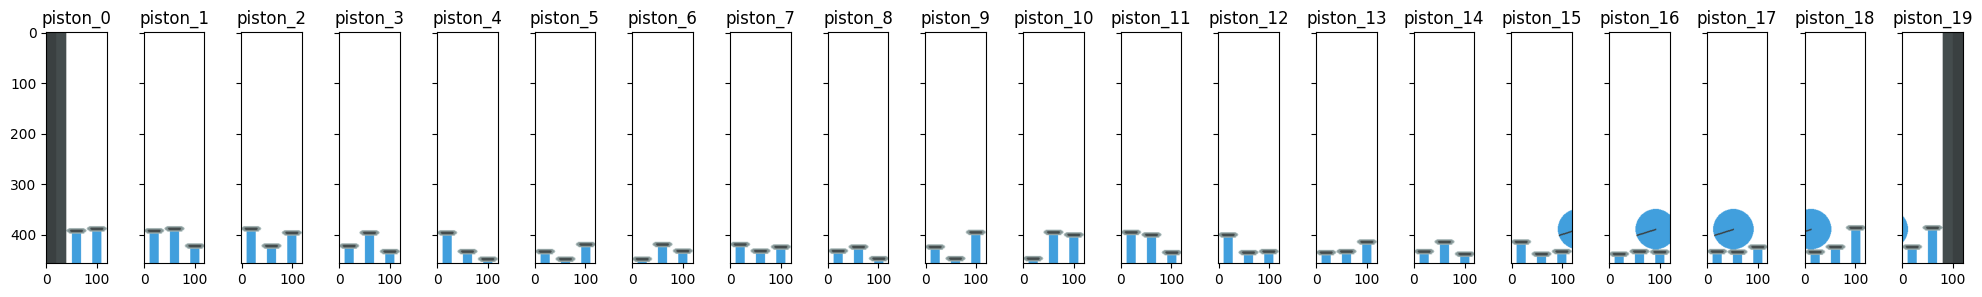

In [43]:
fig, axes = plt.subplots(1,len(observations.keys()), figsize=(25,3))
for i, (key, val) in enumerate(observations.items()):
    ax=axes[i]
    ax.imshow(observations[key])
    ax.set_title(key)
    
for ax in fig.get_axes():
    ax.label_outer()

In [ ]:
import datetime as dt
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')